# Explainability with LLM-MRI: Integrating LIME and SHAP

Este notebook demonstra como usar técnicas de explicabilidade (LIME e SHAP) integradas com a biblioteca LLM-MRI para entender:

1. **Por que certos nós (neurônios) são ativados** para textos específicos
2. **Quais palavras/tokens contribuem mais** para ativações em regiões neurais
3. **Padrões de ativação** por categoria (true vs fake news)


## 1. Setup e Processamento de Áreas de Ativação

In [1]:
import os
from llm_mri import ActivationAreas, NRAGExplainer
from llm_mri.dimensionality_reduction import UMAP
import matplotlib.pyplot as plt
from datasets import load_from_disk
import warnings

# Configuração
model_ckpt = "distilbert/distilbert-base-multilingual-cased"
# dataset_path = "../dataset/dataset_encoded.hf"
dataset_path = '/workspaces/master_degree_lab/datasets/dataset_encoded.hf'


# Carregar dataset
dataset = load_from_disk(dataset_path)
print(f"Dataset loaded: {len(dataset)} samples")
print(f"Classes: {dataset.features['label'].names}")

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset loaded: 40 samples
Classes: ['true', 'fake']


In [2]:
# Definir método de redução de dimensionalidade
umap = UMAP(n_components=10, random_state=42)

# Criar instância do ActivationAreas
llm_mri = ActivationAreas(model=model_ckpt, device="cpu", dataset=dataset, reduction_method=umap)

# Processar áreas de ativação
print("Processando áreas de ativação...")
llm_mri.process_activation_areas()
print(f"Processamento concluído! Número de camadas: {llm_mri.num_layers}")

Processando áreas de ativação...


Map: 100%|██████████| 40/40 [00:08<00:00,  4.50 examples/s]


Processamento concluído! Número de camadas: 7


# Some Random Tests

In [1]:
# llm_mri.dataset["label"]

llm_mri.model
# llm_mri.device
# llm_mri.tokenizer
# llm_mri.class_names
# llm_mri.num_layers


NameError: name 'llm_mri' is not defined

## 2. Inicializar o Explicador NRAG

In [3]:
# Criar instância do explicador
explainer = NRAGExplainer(activation_areas=llm_mri)

print(f"Explicador inicializado!")
print(f"Modelo: {explainer.model_ckpt}")
print(f"Classes: {explainer.class_names}")
print(f"Número de camadas: {explainer.num_layers}")

Explicador inicializado!
Modelo: distilbert/distilbert-base-multilingual-cased
Classes: ['true', 'fake']
Número de camadas: 7


## 3. Treinar Classificadores para os Nós

Cada nó (componente) no NRAG representa uma região neural reduzida. Vamos treinar classificadores binários para prever se um texto ativará cada nó.

In [4]:
# Treinar classificadores para camadas específicas
# Podemos treinar para todas as camadas (layers=None) ou específicas
layers_to_analyze = [3, 6]  # Camadas inicial, média e final

print(f"Treinando classificadores para as camadas: {layers_to_analyze}")
node_classifiers = explainer.train_node_classifiers(layers=layers_to_analyze, threshold=0.5)

print(f"\nTotal de classificadores treinados: {len(node_classifiers)}")
print(f"Primeiros 5 nós: {list(node_classifiers.keys())[:5]}")

Treinando classificadores para as camadas: [3, 6]
Training node classifiers for 2 layers...


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

## 4. Análise de Importância dos Nós

Vamos descobrir quais nós são mais importantes para distinguir entre notícias verdadeiras e falsas.

Análise de Importância - Camada 6

📊 Top 5 nós mais importantes para 'true':



,component,node_id,mean_activation_category,mean_activation_other,importance_score
7,7,layer_6_comp_7,3.442342,2.354238,1.088104
6,6,layer_6_comp_6,5.629274,5.194070,0.435204
5,5,layer_6_comp_5,2.133559,1.862158,0.271401
2,2,layer_6_comp_2,9.705662,9.523351,0.182311
8,8,layer_6_comp_8,7.928837,7.890606,0.038231


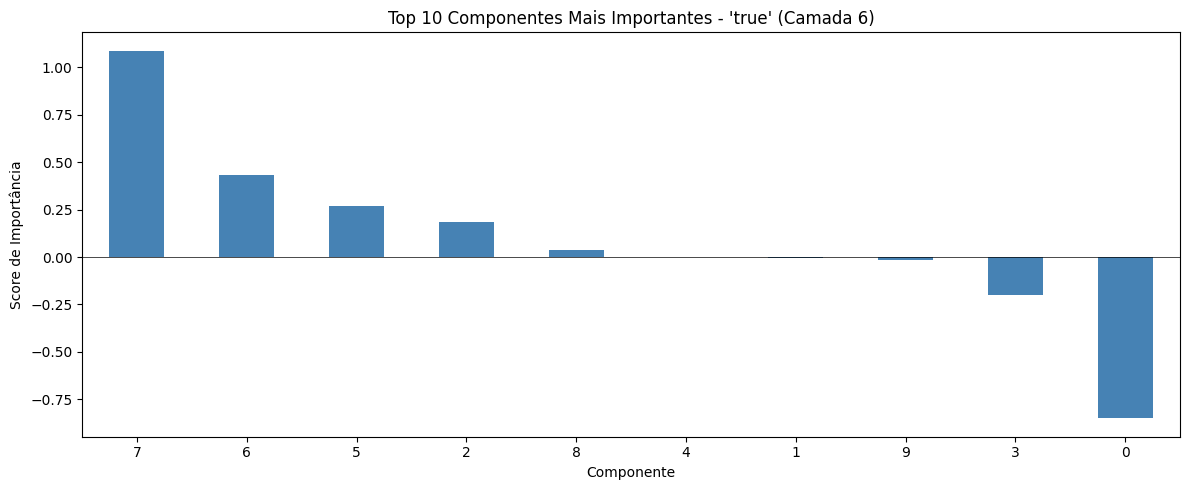


📊 Top 5 nós mais importantes para 'fake':



,component,node_id,mean_activation_category,mean_activation_other,importance_score
0,0,layer_6_comp_0,10.282378,9.431722,0.850657
3,3,layer_6_comp_3,11.875826,11.673006,0.202820
9,9,layer_6_comp_9,8.121964,8.108366,0.013598
1,1,layer_6_comp_1,5.640812,5.634444,0.006368
4,4,layer_6_comp_4,10.331336,10.331953,-0.000617


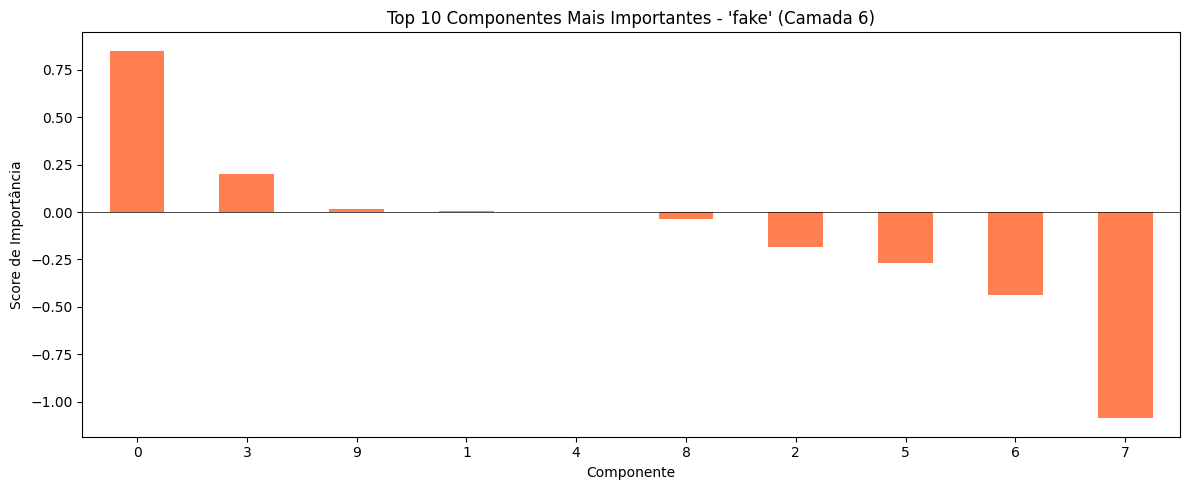

In [5]:
import pandas as pd

# Analisar importância dos nós para cada categoria
layer_to_analyze = 6

print(f"=" * 80)
print(f"Análise de Importância - Camada {layer_to_analyze}")
print(f"=" * 80)

for category in ['true', 'fake']:
    print(f"\n📊 Top 5 nós mais importantes para '{category}':\n")
    importance_df = explainer.analyze_node_importance(layer=layer_to_analyze, category=category)
    
    # Mostrar top 5
    display(importance_df.head(5))
    
    # Visualizar
    fig, ax = plt.subplots(figsize=(12, 5))
    importance_df.head(10).plot(
        x='component', 
        y='importance_score', 
        kind='bar', 
        ax=ax,
        color='steelblue' if category == 'true' else 'coral',
        legend=False
    )
    ax.set_title(f"Top 10 Componentes Mais Importantes - '{category}' (Camada {layer_to_analyze})")
    ax.set_xlabel("Componente")
    ax.set_ylabel("Score de Importância")
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

## 5. Encontrar Textos que Mais Ativam Nós Específicos

In [6]:
# Escolher um nó para analisar
layer = 6
component = 0  # Pode mudar para qualquer componente

print(f"🔍 Textos que mais ativam o Nó (Camada {layer}, Componente {component})\n")
print("=" * 80)

for category in ['true', 'fake']:
    print(f"\n📰 Categoria: {category.upper()}\n")
    
    top_texts = explainer.get_most_activating_texts(
        layer=layer,
        component=component,
        category=category,
        top_k=3
    )
    
    for idx, (i, row) in enumerate(top_texts.iterrows(), 1):
        print(f"\n{idx}. Ativação: {row['activation']:.4f}")
        print(f"   Texto: {row['text'][:300]}...")
        print("-" * 80)

🔍 Textos que mais ativam o Nó (Camada 6, Componente 0)


📰 Categoria: TRUE


1. Ativação: 10.9905
   Texto: podemos decidiu expulsar deputado federal carlos gaguim partido apos policia federal fazer buscas apreensoes gabinete camara legenda abre espaco receber senadora expulsa pmdb katia abreu meio nota legenda informou afastamento parlamentar algo acordado filiados sigla ainda parlamentar comunicado conc...
--------------------------------------------------------------------------------

2. Ativação: 10.9382
   Texto: prefeito manaus arthur virgilio psdb ter enviado carta cobrando previas partido definir candidato presidencia republica governador paulo presidente partido geraldo alckmin negou racha legenda alckmin disse nesta previa divide previa escolhe dois postulam cargo candidato presidente previa divide prev...
--------------------------------------------------------------------------------

3. Ativação: 10.7855
   Texto: laudo declara paulo maluf pode continuar presidio papuda i